Running on cpu



/state/partition1/job-64630969/ipykernel_2917102/3587867364.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ann_ckpt = torch.load(ANN_CKPT, map_location="cpu")
/state/


===  Forcing F =  5.0  |  centre traj ID 0  ===
Running: Numerical vs Numerical


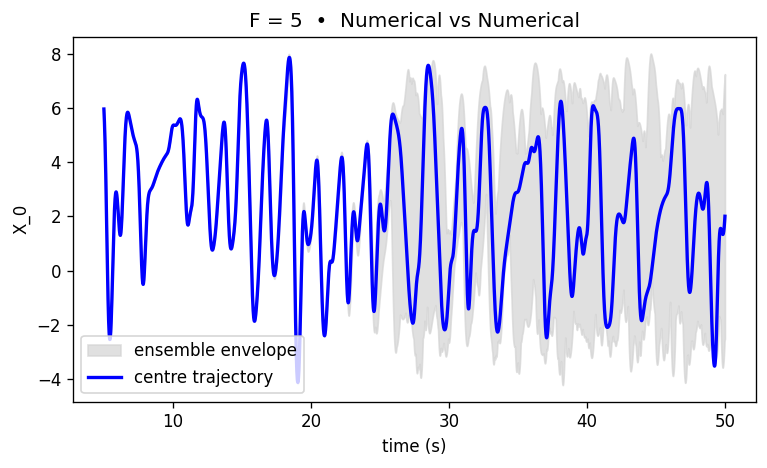

Running: ANN-ΔX + AB3 vs Numerical


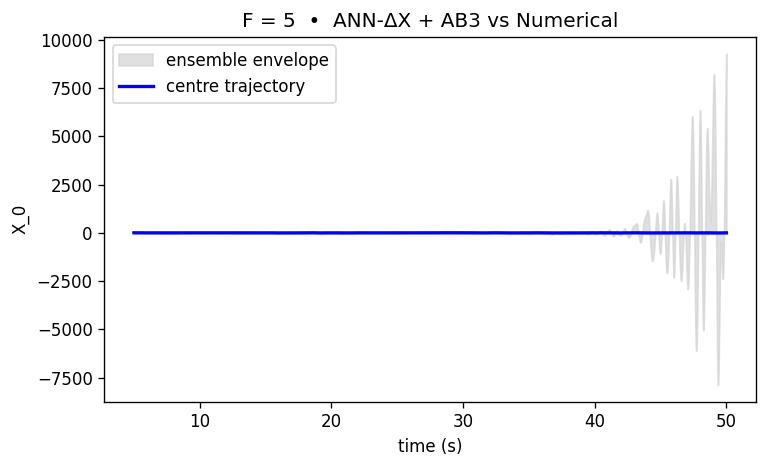

Running: ANN-ΔX + AB3 vs ANN-ΔX + AB3


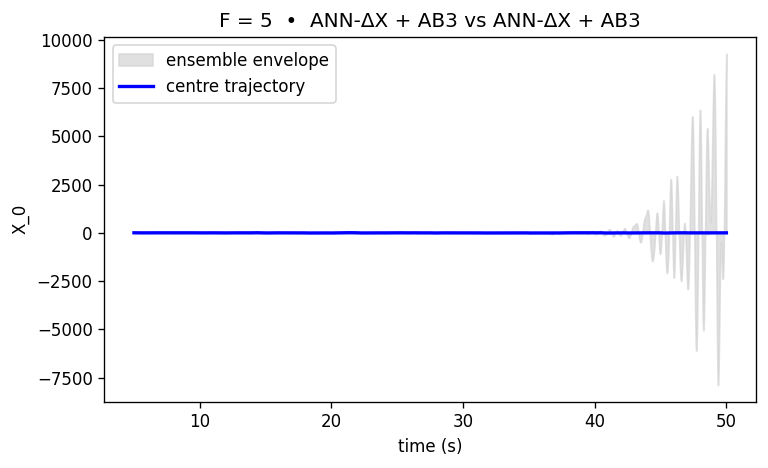

Running: LSTM-ΔX + AB3 vs Numerical


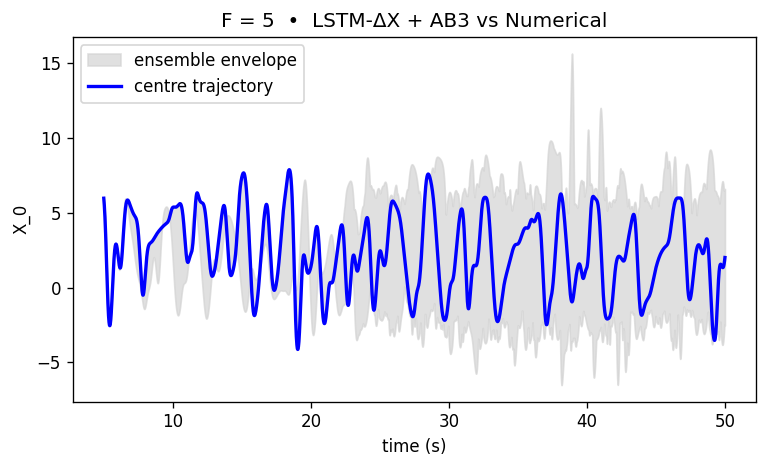

Running: LSTM-ΔX + AB3 vs LSTM-ΔX + AB3


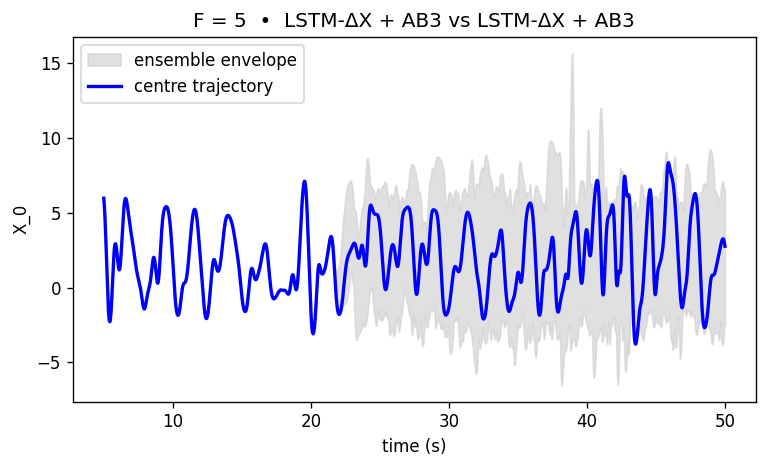


===  Forcing F = 10.0  |  centre traj ID 1  ===
Running: Numerical vs Numerical


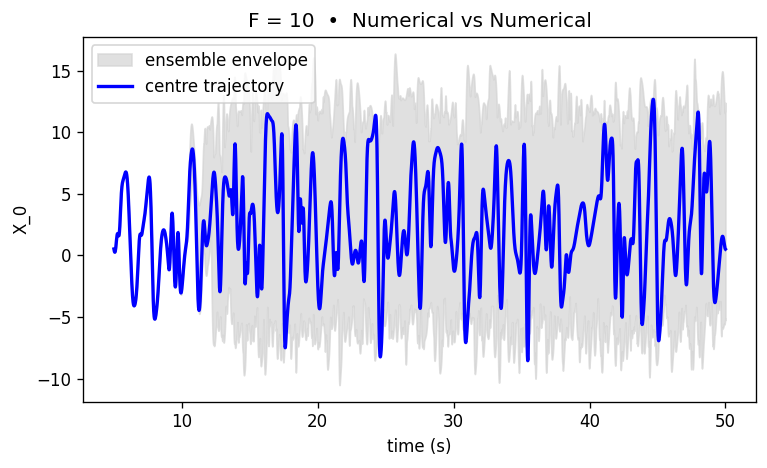

Running: ANN-ΔX + AB3 vs Numerical


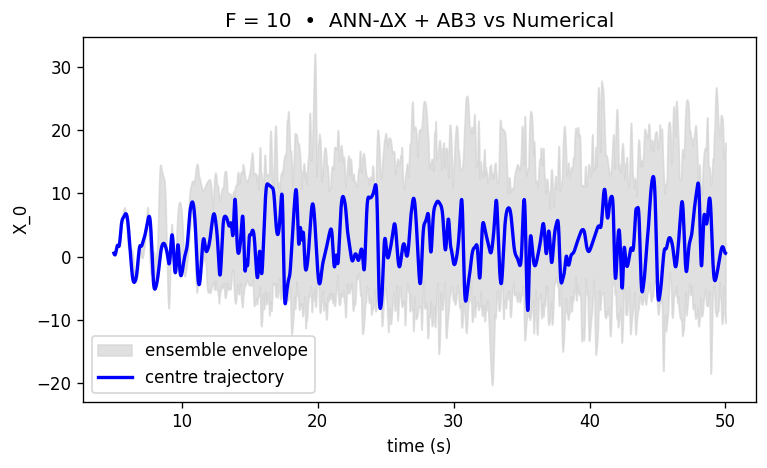

Running: ANN-ΔX + AB3 vs ANN-ΔX + AB3


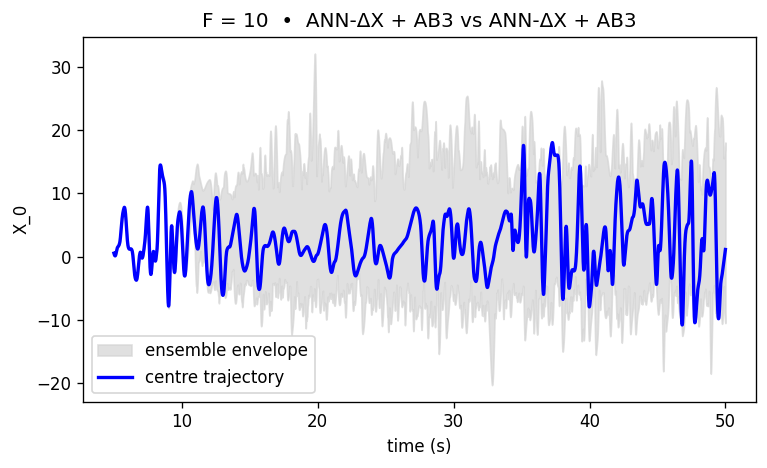

Running: LSTM-ΔX + AB3 vs Numerical


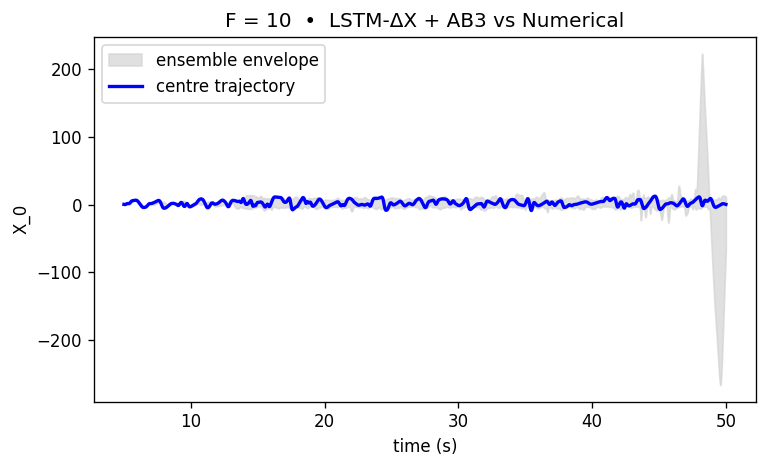

Running: LSTM-ΔX + AB3 vs LSTM-ΔX + AB3


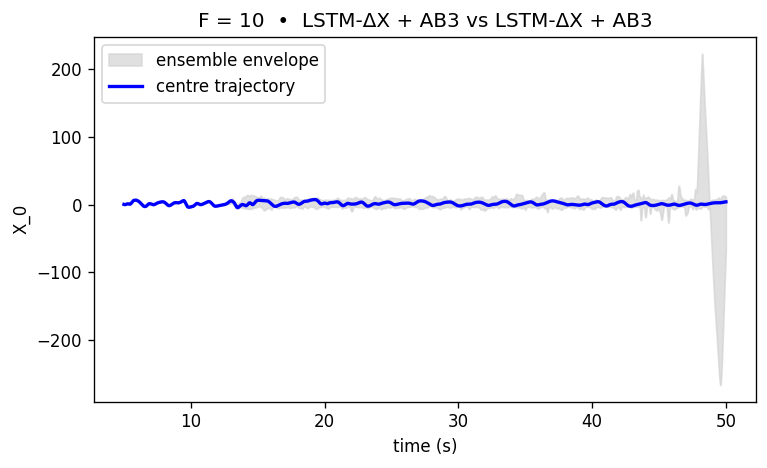


===  Forcing F = 15.0  |  centre traj ID 2  ===
Running: Numerical vs Numerical


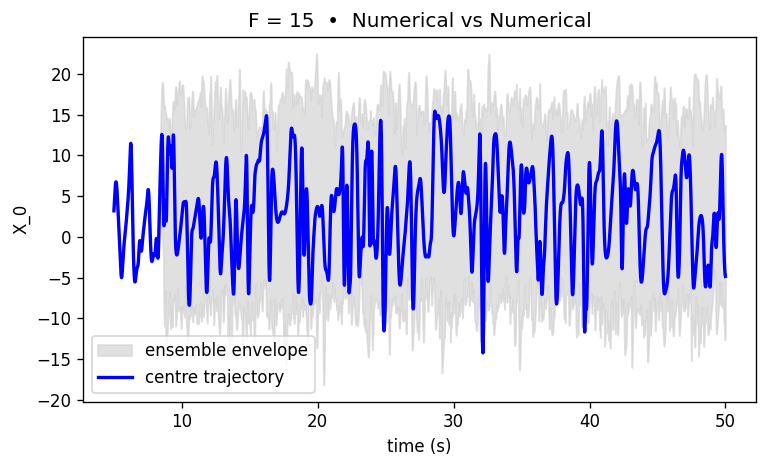

Running: ANN-ΔX + AB3 vs Numerical


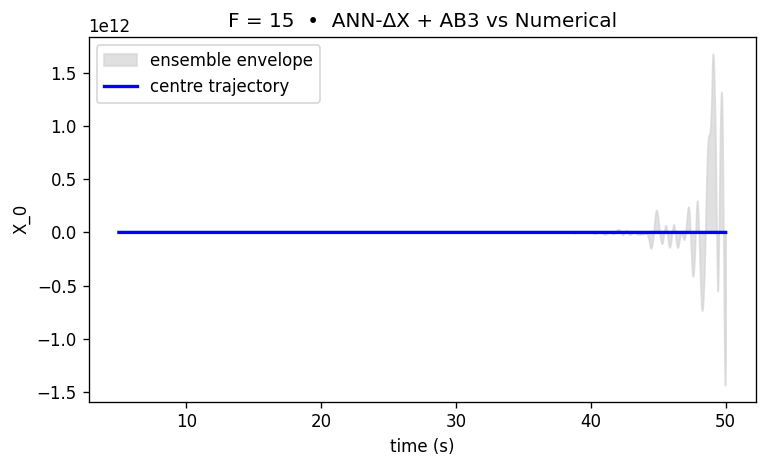

Running: ANN-ΔX + AB3 vs ANN-ΔX + AB3


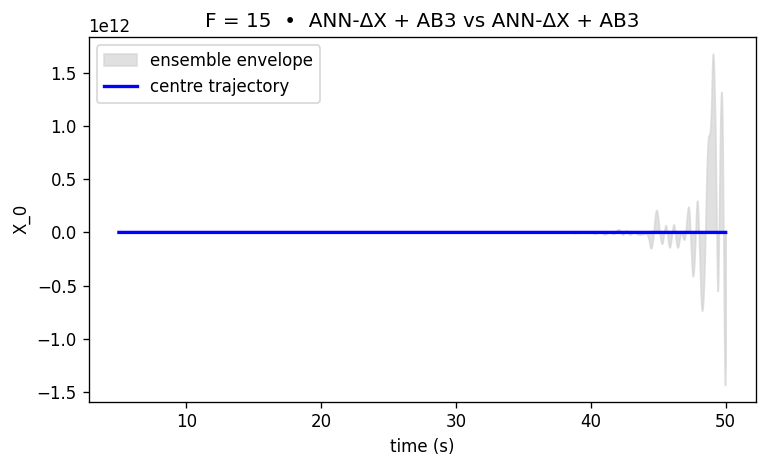

Running: LSTM-ΔX + AB3 vs Numerical


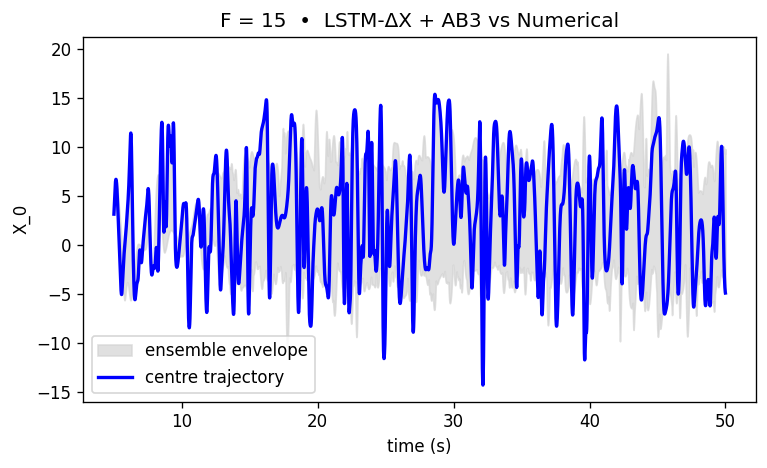

Running: LSTM-ΔX + AB3 vs LSTM-ΔX + AB3


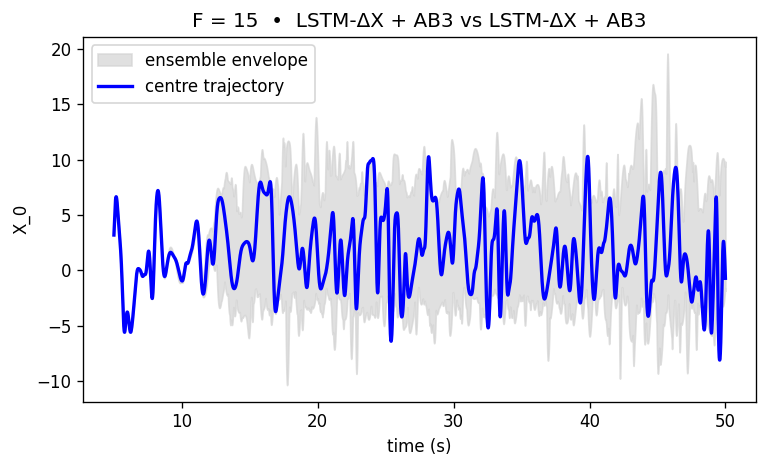


Finished all multi-forcing divergence plots.


In [1]:
#!/usr/bin/env python3
# =============================================================================
#  Multi-forcing divergence / error-growth study
#  --------------------------------------------
#  • Dataset           : Lorenz-96, forcings F = 5, 10, 15  (implicit model)
#  • Error models      : 
#         – numerical RK-4 (“truth”)
#         – ΔX-ANN  + Euler→AB-3 roll-out
#         – ΔX-LSTM + Euler→AB-3 roll-out
#  • Scenarios plotted : five pair-wise comparisons for each forcing
#  • Ensemble          : K = 50 members, Gaussian perturbations radius ε
#  • Output            : 15 plots showing the spread of state X_0(t)
#
#  Patched 2025-07-30 – loop-index bug fixed in rollout_ann_dx / rollout_lstm_dx.
#  Added detailed comments for clarity.
# =============================================================================

import os, copy, math, warnings
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

# ────────────────────────────────────────────────────────────────────────────
#                       0.  HOUSE-KEEPING AND GLOBALS
# ────────────────────────────────────────────────────────────────────────────
warnings.filterwarnings("ignore", category=UserWarning)  # mute matplotlib bitmaps
torch.set_printoptions(sci_mode=False, linewidth=120)    # nicer tefonsor printing

# ------------ simulation window & ensemble params ------------
DT        = 0.005                 # time-step used in all training
T0        = 5.0                   # simulations start here (skip spin-up)
T_END     = 50.0                  # final time (matches training window)
EPS       = 1e-5                  # perturbation radius ε
K         = 50                    # ensemble size
RADIUS    = EPS * math.sqrt(5/3)  # √(5/3) converts ε-sphere to ε-RMSE
STATE_TO_PLOT = 0                 # X_0(t) is what we visualise

# ------------ forcing values to study ------------
FORCINGS   = [5.0, 10.0, 15.0]    # must exist in the shifted dataset

# ------------ data / checkpoint files ------------
SHIFTED_FILE = "shifted_force5_10_15_data.npz"        # unseen trajectories
TRAIN_FILE   = "force_5_10_15_data.npz"               # for μ / σ fallback
ANN_CKPT     = "standard_early_stopping_F5_10_15_ann.pt"
LSTM_CKPT    = "standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt"
#                                   ↑ replace `q14` if you picked a different q

# ────────────────────────────────────────────────────────────────────────────
#                           1.  DEVICE SELECTION
# ────────────────────────────────────────────────────────────────────────────
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE.type == "cpu":                       # keep CPU jobs snappy
    torch.set_num_threads(min(14, os.cpu_count()))
print(f"Running on {DEVICE}\n")

# ────────────────────────────────────────────────────────────────────────────
#                    2.  LORENZ-96 INTEGRATORS (NumPy + Torch)
# ────────────────────────────────────────────────────────────────────────────
# ----------- Torch version (vectorised, differentiable) ----------------
def l96_rhs_t(x, F):
    """Lorenz-96 RHS, PyTorch (batch-friendly, last dim = state)."""
    return (torch.roll(x,-1,-1) - torch.roll(x, 2, -1)) * torch.roll(x, 1, -1) - x + F

def rk4_step_t(x, dt, F):
    """One RK-4 step, PyTorch."""
    k1 = l96_rhs_t(x, F)
    k2 = l96_rhs_t(x + 0.5 * dt * k1, F)
    k3 = l96_rhs_t(x + 0.5 * dt * k2, F)
    k4 = l96_rhs_t(x + dt  * k3, F)
    return x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

# ----------- NumPy flavour (for baseline roll-outs) ---------------------
def rk4_step_np(x, dt, F):
    """One RK-4 step, NumPy (single trajectory)."""
    def rhs(x_):
        return (np.roll(x_,-1) - np.roll(x_,2)) * np.roll(x_,1) - x_ + F
    k1 = rhs(x); k2 = rhs(x + 0.5 * dt * k1)
    k3 = rhs(x + 0.5 * dt * k2); k4 = rhs(x + dt * k3)
    return x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

# ----------- Adams-Bashforth-3 helper -----------------------------------
def ab3_step(dx1, dx_prev1, dx_prev2):
    """Return ΔX based on Euler / AB-2 / AB-3 depending on history length."""
    if dx_prev1 is None:   return dx1                       # Euler (first step)
    if dx_prev2 is None:   return 1.5*dx1 - 0.5*dx_prev1    # AB-2
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2   # AB-3

# ────────────────────────────────────────────────────────────────────────────
#                3.  LOAD DATA & GLOBAL NORMALISATION STATS
# ────────────────────────────────────────────────────────────────────────────
shifted = np.load(SHIFTED_FILE)
X_shift = shifted["X"].astype(np.float32)   # shape: (traj, step, 36)
F_shift = shifted["F"].astype(np.float32)

# Numerical time axes
steps_5s   = int(round(T0 / DT))
steps_end  = int(round(T_END / DT))
n_steps_sim = steps_end - steps_5s          # number of simulation steps
t_vec      = np.arange(n_steps_sim + 1) * DT + T0

# Fallback μ / σ (in case the checkpoints don’t store them)
μσ_train   = np.load(TRAIN_FILE)["X"].astype(np.float32).reshape(-1, 36)
μ_fallback = torch.tensor(μσ_train.mean(0)).float()
σ_fallback = torch.tensor(μσ_train.std (0) + 1e-8).float()

# ────────────────────────────────────────────────────────────────────────────
#                        4.  LOAD ΔX MODELS
# ────────────────────────────────────────────────────────────────────────────
# ---------- 4.1  Feed-forward ANN (multi-forcing) ------------------------
def make_mlp(sizes=(36, 128, 128, 64, 36)):
    """Simple fully-connected network with ReLU activations."""
    import torch.nn as nn
    layers = []
    for i in range(len(sizes)-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if i < len(sizes) - 2:
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)

ann = make_mlp().to(DEVICE).eval()
ann_ckpt = torch.load(ANN_CKPT, map_location="cpu")
ann.load_state_dict(ann_ckpt["net"])
μ_ad = torch.tensor(ann_ckpt.get("mean", μ_fallback)).float().to(DEVICE)
σ_ad = torch.tensor(ann_ckpt.get("std" , σ_fallback)).float().to(DEVICE)

# ---------- 4.2  Single-layer LSTM (multi-forcing) -----------------------
lstm_ckpt = torch.load(LSTM_CKPT, map_location="cpu")
hidden_l  = int(lstm_ckpt["hidden_size"])     # hidden size H = 70
q_lstm    = int(lstm_ckpt["lookback"])        # look-back window length

class SingleLayerLSTM(torch.nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.lstm = torch.nn.LSTM(36, hidden, batch_first=True)
        self.head = torch.nn.Linear(hidden, 36)
    def forward(self, win):                  # win : (B, q, 36)
        y, _ = self.lstm(win)
        return self.head(y[:, -1])           # ΔX̂_norm

lstm = SingleLayerLSTM(hidden_l).to(DEVICE).eval()
lstm.load_state_dict(lstm_ckpt["net"])
μ_ld = torch.tensor(lstm_ckpt.get("mean", μ_fallback)).float().to(DEVICE)
σ_ld = torch.tensor(lstm_ckpt.get("std" , σ_fallback)).float().to(DEVICE)

# ────────────────────────────────────────────────────────────────────────────
#                   5.  ROLL-OUT HELPERS (NUM / ANN / LSTM)
# ────────────────────────────────────────────────────────────────────────────
@torch.no_grad()
def rollout_num(x0, F):
    """Deterministic RK-4 baseline trajectory (NumPy output)."""
    out = np.empty((n_steps_sim+1, 36), np.float32)
    out[0] = x0
    x = torch.from_numpy(x0).float().to(DEVICE)
    for s in range(1, n_steps_sim+1):
        x  = rk4_step_t(x, DT, F)
        out[s] = x.cpu().numpy()
    return out

@torch.no_grad()
def rollout_ann_dx(x0, _F_unused):
    """
    Roll-out with ΔX-ANN + Euler→AB-3.
    _F_unused is here for API symmetry (model is forcing-agnostic).
    """
    out = np.empty((n_steps_sim+1, 36), np.float32)
    out[0] = x0

    # Current state in normalised space
    x_norm = (torch.from_numpy(x0).float().to(DEVICE) - μ_ad) / σ_ad
    dx_prev1 = dx_prev2 = None

    for s in range(1, n_steps_sim+1):
        dx1  = ann(x_norm.unsqueeze(0)).squeeze(0)    # ΔX̂_norm
        step = ab3_step(dx1, dx_prev1, dx_prev2)
        x_norm = x_norm + step
        dx_prev2, dx_prev1 = dx_prev1, dx1
        out[s] = (x_norm * σ_ad + μ_ad).cpu().numpy() # back to physical units
    return out

@torch.no_grad()
def rollout_lstm_dx(x0, _F_unused):
    """
    Roll-out with ΔX-LSTM + Euler→AB-3.  Uses sliding window of length q_lstm.
    """
    out = np.empty((n_steps_sim+1, 36), np.float32)
    out[0] = x0

    # Initial window = q_lstm duplicates of the starting state (normalised)
    win = np.tile(x0, (q_lstm, 1)).astype(np.float32)
    win_t = torch.from_numpy((win - μ_ld.cpu().numpy()) / σ_ld.cpu().numpy()) \
               .float().to(DEVICE)

    dx_prev1 = dx_prev2 = None
    for s in range(1, n_steps_sim+1):
        dx1   = lstm(win_t.unsqueeze(0)).squeeze(0)   # ΔX̂_norm over window
        step  = ab3_step(dx1, dx_prev1, dx_prev2)
        new_state_norm = win_t[-1] + step

        # Slide window: drop first, append new state
        win_t = torch.cat([win_t[1:], new_state_norm.unsqueeze(0)], 0)
        dx_prev2, dx_prev1 = dx_prev1, dx1
        out[s] = (new_state_norm * σ_ld + μ_ld).cpu().numpy()
    return out

# ────────────────────────────────────────────────────────────────────────────
#                    6.  EXPERIMENT SCENARIO MATRIX
# ────────────────────────────────────────────────────────────────────────────
SCENARIOS = [
    ("Numerical vs Numerical",            rollout_num,     rollout_num    ),
    ("ANN-ΔX + AB3 vs Numerical",         rollout_num,     rollout_ann_dx ),
    ("ANN-ΔX + AB3 vs ANN-ΔX + AB3",      rollout_ann_dx,  rollout_ann_dx ),
    ("LSTM-ΔX + AB3 vs Numerical",        rollout_num,     rollout_lstm_dx),
    ("LSTM-ΔX + AB3 vs LSTM-ΔX + AB3",    rollout_lstm_dx, rollout_lstm_dx)
]

# ────────────────────────────────────────────────────────────────────────────
#        7.  MAIN LOOP OVER FORCINGS & PLOT THE ENSEMBLE ENVELOPES
# ────────────────────────────────────────────────────────────────────────────
for F in FORCINGS:
    # -- pick *first* shifted trajectory with the desired forcing ----------
    idxs = np.where(F_shift == F)[0]
    if idxs.size == 0:
        raise RuntimeError(f"No trajectory with F = {F} in {SHIFTED_FILE}")
    centre_id  = idxs[0]
    x0_centre  = X_shift[centre_id, steps_5s].copy()

    # -- deterministic ensemble around the centre trajectory ---------------
    rng = np.random.default_rng(0)  # reproducible
    ensemble0 = x0_centre + RADIUS * rng.standard_normal((K, 36)).astype(np.float32)

    print(f"\n===  Forcing F = {F:>4.1f}  |  centre traj ID {centre_id}  ===")

    for title, centre_fn, ens_fn in SCENARIOS:
        print(f"Running: {title}")

        # ----------------- roll out centre & ensemble ----------------------
        centre_traj = centre_fn(copy.deepcopy(x0_centre), F)
        ens_trajs   = np.stack([ens_fn(copy.deepcopy(e), F) for e in ensemble0])

        # -------- build envelope (min/max over ensemble + centre) ---------
        all_stack = np.concatenate([centre_traj[None], ens_trajs], axis=0)
        y_min = all_stack[:, :, STATE_TO_PLOT].min(0)
        y_max = all_stack[:, :, STATE_TO_PLOT].max(0)

        # ---------------------------- plot --------------------------------
        plt.figure(figsize=(6.5, 4), dpi=120)
        plt.fill_between(t_vec, y_min, y_max,
                         color="lightgrey", alpha=0.7,
                         label="ensemble envelope")
        plt.plot(t_vec, centre_traj[:, STATE_TO_PLOT],
                 lw=2, color="blue", label="centre trajectory")
        plt.xlabel("time (s)")
        plt.ylabel(f"X_{STATE_TO_PLOT}")
        plt.title(f"F = {F:g}  •  {title}")
        plt.legend(); plt.tight_layout(); plt.show()

print("\nFinished all multi-forcing divergence plots.")
